In [ ]:
# default_exp repr.word2vec.eval

# Evaluating Word2Vec and Doc2vec (basic)

> This module is dedicated to evaluate word2vec training with a proxy dataset:
> No training module. 
>
> Goal: Here we want to test the quality of the (trained) model independent on SE domain
>
>
> Author: @danaderp April 2020

In [ ]:
# export
# Imports
import numpy as np
import gensim
import pandas as pd
from itertools import product 
from random import sample 
import functools 

In [ ]:
# export
#Visualizing wordEmbedding
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

In [ ]:
#hide
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
!pip install pyemd

In [ ]:
#Loading Artifacts
artifacts = pd.read_csv('/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv')
texts = [doc.split() for doc in list(artifacts['0'])]

## Basic Assessment Word2vec

In [ ]:
word2vec_model = gensim.models.Word2Vec.load("test_data/models/word2vec_libest.model")

In [ ]:
word2vec_model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

In [ ]:
#Testing Distance
distance = word2vec_model.wv.wmdistance(texts[0], texts[1])

In [ ]:
print(texts[0],texts[1],distance)

In [ ]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

In [ ]:
x_vals, y_vals, labels = reduce_dimensions(word2vec_model)

In [ ]:
try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

In [ ]:
plot_function(x_vals, y_vals, labels)

In [ ]:
%matplotlib inline
plot_with_matplotlib(x_vals, y_vals, labels)

## Basic Assessment Doc2Vec

In [ ]:
import math as m
import random as r
import collections

In [ ]:
doc2vec_model = gensim.models.Doc2Vec.load("test_data/models/doc2vec_libest.model")

2020-05-04 20:03:58,913 : INFO : loading Doc2Vec object from test_data/models/doc2vec_libest.model
2020-05-04 20:03:58,986 : INFO : loading vocabulary recursively from test_data/models/doc2vec_libest.model.vocabulary.* with mmap=None
2020-05-04 20:03:58,987 : INFO : loading trainables recursively from test_data/models/doc2vec_libest.model.trainables.* with mmap=None
2020-05-04 20:03:58,988 : INFO : loading wv recursively from test_data/models/doc2vec_libest.model.wv.* with mmap=None
2020-05-04 20:03:58,989 : INFO : loading docvecs recursively from test_data/models/doc2vec_libest.model.docvecs.* with mmap=None
2020-05-04 20:03:58,990 : INFO : loaded test_data/models/doc2vec_libest.model


In [ ]:
s = m.floor(len(texts)*0.1)
test_corpus = [i[1] for i in enumerate(texts[:s])]
train_corpus = [gensim.models.doc2vec.TaggedDocument(i[1], [i[0]]) for i in enumerate(texts[s:])]

In [ ]:
assert len(doc2vec_model.docvecs) == len(train_corpus)
print(len(doc2vec_model.docvecs), len(train_corpus))

79 79


In [ ]:
#Self-similarity assessment
ranks = []
second_ranks = []

In [ ]:
for doc_id in range(len(train_corpus)):
    inferred_vector = doc2vec_model.infer_vector(train_corpus[doc_id].words)
    sims = doc2vec_model.docvecs.most_similar([inferred_vector], topn=len(doc2vec_model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

Checking the inferred-vector against a training-vector is a sort of ‘sanity check’ as to whether the model is behaving in a usefully consistent manner, though not a real ‘accuracy’ value.

In [ ]:
counter = collections.Counter(ranks)
print(counter)

Counter({0: 79})


In [ ]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (78): «util function set certif privat key use ssl context return success int est client set cert key ssl ctx ctx cert evp pkey key ssl ctx use certif ctx cert est log err error set certif ossl dump ssl error return ssl ctx use privat key ctx key est log err unabl set privat key ossl dump ssl error return verifi key match cert ssl ctx check privat key ctx est log err privat key match certif public key ossl dump ssl error return return sign certif request use digest key pass return open ssl error code req sign ctx static int est client req sign req evp pkey pkey const evp int evp pkey ctx pkctx null evp ctx mctx evp ctx init mctx evp digest sign init mctx pkctx null pkey return encod use der asn set modifi flag req open ssl keep cach copi der encod data case set flag tell open ssl run asn encod rather use cach copi req info enc modifi req sign ctx mctx evp ctx cleanup mctx return popul request build request buffer call open ssl insert field header paramet req pointer buffer hol

NameError: name 'model' is not defined

In [ ]:
#Pick a random artifact from the corpus and infer a vector from the model
doc_id = r.randint(0, len(train_corpus) -1 )

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(train_corpus[sim_id[0]].words)))

Train Document (12): «unit test user stori proxi csr attribut novemb copyright cisco system inc right reserv includ stdio ifndef win includ unistd endif includ est includ curl curl includ curl util includ test util includ server includ proxi includ openssl ssl ifdef cunit includ cunit basic includ cunit autom endif static unsign char cacert null static int cacert len defin server port defin proxi port ifndef win32 defin us895_cacert est cacert crt defin us895_trusted_cert trustedcert crt defin server_ut_cacert est cacert crt defin server_ut_pubkey "./ defin us895_server_ip 127 defin us895_cacert est cacert crt defin us895_trust_cert trustedcert crt defin us895_server_certkey est privat estservercertandkey pem els defin us895_cacert est cacert crt defin us895_trusted_cert trustedcert crt defin server_ut_cacert est cacert crt defin server_ut_pubkey defin us895_server_ip 127 defin us895_cacert est cacert crt defin us895_trust_cert trustedcert crt defin us895_server_certkey est privat ests

## Testing the Model

In [ ]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = r.randint(0, len(test_corpus) - 1)
inferred_vector = doc2vec_model.infer_vector(test_corpus[doc_id])
sims = doc2vec_model.docvecs.most_similar([inferred_vector], topn=len(doc2vec_model.docvecs))

In [ ]:
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id][:10])))

Test Document (4): «unit test user stori client cacert june copyright cisco system»



In [ ]:
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % doc2vec_model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words[:10])))

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc2,s0.001,t3):

MOST (3, 0.8158812522888184): «unit test uri path segment support server april copyright cisco»

MEDIAN (58, 0.34024176001548767): «requir distribut certif est client request copi current certif function»

LEAST (67, -0.042235516011714935): «file est est public api enrol secur transport novemb copyright»



In [ ]:
# Compare and print the most/median/least similar documents from the train corpus
train_corpus[0].words[:10]

['unit',
 'test',
 'user',
 'stori',
 'proxi',
 'cacert',
 'novemb',
 'copyright',
 'cisco',
 'system']

In [ ]:
sims

[(3, 0.8158812522888184),
 (0, 0.5824273824691772),
 (38, 0.529496431350708),
 (32, 0.5204856395721436),
 (68, 0.5187431573867798),
 (13, 0.5158644914627075),
 (55, 0.5089541077613831),
 (7, 0.5078519582748413),
 (12, 0.49339187145233154),
 (54, 0.4914425313472748),
 (41, 0.4846417307853699),
 (31, 0.48334723711013794),
 (2, 0.4753178060054779),
 (28, 0.4736562669277191),
 (50, 0.4709679186344147),
 (23, 0.46533653140068054),
 (49, 0.4650142788887024),
 (6, 0.45413604378700256),
 (21, 0.43835797905921936),
 (45, 0.42663583159446716),
 (44, 0.42608878016471863),
 (18, 0.42147570848464966),
 (1, 0.41947343945503235),
 (59, 0.4137580096721649),
 (48, 0.4106936454772949),
 (11, 0.4029121994972229),
 (16, 0.40119242668151855),
 (42, 0.38525792956352234),
 (65, 0.3822197914123535),
 (34, 0.38073045015335083),
 (47, 0.37991195917129517),
 (5, 0.3794174790382385),
 (36, 0.3775385022163391),
 (60, 0.35832998156547546),
 (52, 0.3570764362812042),
 (64, 0.35673457384109497),
 (40, 0.3523876070976

## Proximity and Visualization

In [ ]:
def reduce_dimensions_doc2vec(model, corpus_list, num_dimensions=2):
    # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    
    #TODO Label corpus_list so that we can idetify the documents
    
    for artifact in corpus_list:
        inf = model.infer_vector( artifact , steps=200 )
        vectors.append(inf)
        #labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    #labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
vectors = [] # positions in vector space

In [ ]:
for artifact in texts:
    inf = doc2vec_model.infer_vector( artifact , steps=200 )
    vectors.append(inf)

In [ ]:
vectors

[array([ -1.1465187 ,  -0.6769659 ,  -3.9466546 ,  -6.537429  ,
         -3.8264825 ,  12.494371  ,  -5.766705  ,  -1.0662086 ,
          1.3832403 ,  -1.912242  ,  -1.4875673 ,  10.58467   ,
          3.686105  ,   3.558232  ,  -4.604556  ,  -1.3376732 ,
         -0.5743203 ,  -8.368489  ,   3.4940586 ,   2.4422183 ,
          0.5074329 ,  -5.1088495 ,  -5.163845  ,  -0.4432285 ,
          4.0761046 , -12.123232  ,  -7.4725723 ,   2.9386153 ,
          5.944546  , -13.662391  ,  -3.0842416 ,  -1.0733452 ,
         -1.6143372 ,   0.9102877 ,   3.1954427 ,  -3.509083  ,
         -7.058819  ,  -1.234161  ,   8.203302  ,   4.1657586 ,
         -4.8018246 ,  -6.889636  ,   1.4879539 ,  -1.5300335 ,
          1.4753006 ,   6.5450616 ,   1.9208316 ,  -3.8650882 ,
          2.8737607 ,  -0.62818646], dtype=float32),
 array([-7.990206  , -3.1529071 , -2.1322663 ,  0.22888356, -9.022792  ,
         1.0410435 , -8.687231  , -0.26636696,  0.59159315,  0.44963646,
        -2.55227   ,  3.760346  ,

In [ ]:
vectors = np.asarray(vectors)

In [ ]:
vectors.shape

(87, 50)

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
vectors = tsne.fit_transform(vectors)

In [ ]:
df_reduced_vector = pd.DataFrame(vectors,columns=['tsne1', 'tsne2'])

In [ ]:
#check here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.scatter.html
df_reduced_vector.head()

,tsne1,tsne2
0,-113.940987,-34.413414
1,-72.304749,-85.056465
2,-54.885780,-34.727982
3,7.314480,100.819092
4,-55.143200,-64.941833


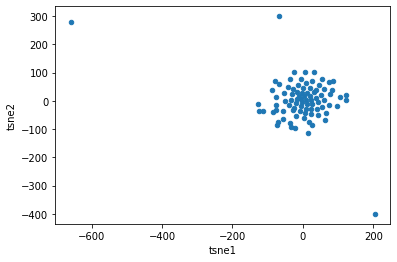

In [ ]:
ax1 = df_reduced_vector.plot.scatter(x='tsne1', y='tsne2')

In [ ]:
! nbdev_build_docs